# Understanding the data and performing regressions


# Step 1: Import helpful libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from mlxtend.preprocessing import minmax_scaling

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Step 2: Load the data

Next, we'll load the training and test data.  

We set `index_col=0` in the code cell below to use the `id` column to index the DataFrame.  (*If you're not sure how this works, try temporarily removing `index_col=0` and see how it changes the result.*)

In [2]:
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv", index_col=0)
test = pd.read_csv("../input/30-days-of-ml/test.csv", index_col=0)

# Preview the data
train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


#### Learning more about our data

In [3]:
train.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target'>

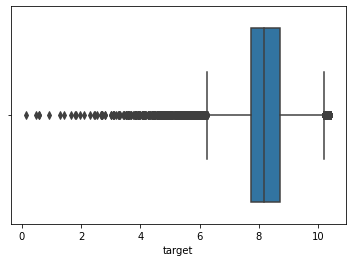

In [4]:
sns.boxplot(train['target'])

### Observations:

- Train set has 300,000 rows while test set has 200,000 rows.
- There are 10 categorical features from `cat0` - `cat9` and 14 continuous features from `cont0` - `cont13`.
- There is no missing values in the train and test dataset but there is no category `G` in `cat6` test dataset.
- Categorical features ranging from alphabet A - O but it varies from each categorical feature with `cat0`, `cat1`, `cat3`, `cat5` and `cat6` are dominated by one category.
- Continuous features on train anda test dataset ranging from -0.1 to 1.25 which are a multimodal distribution and they resemble each other.
- target has a range between 6.8 to 10.5 and has a bimodal distribution.


Ideas:

Drop features that are dominated by one category cat0, cat1, cat3, cat5 and cat6 as they don't give variation to the dataset but further analysis still be needed.

In [5]:
cat_features = [feature for feature in train.columns if 'cat' in feature]
cont_features = [feature for feature in train.columns if 'cont' in feature]

#### Number of rows and columns

In [6]:
print('Rows and Columns in train dataset:', train.shape)
print('Rows and Columns in test dataset:', test.shape)

Rows and Columns in train dataset: (300000, 25)
Rows and Columns in test dataset: (200000, 24)


#### Number of missing values

In [7]:
print('Missing values in train dataset:', sum(train.isnull().sum()))
print('Missing values in test dataset:', sum(test.isnull().sum()))

Missing values in train dataset: 0
Missing values in test dataset: 0


# Step 3: Features and target correlation

### Basic statistics on continuous features

#### Train dataset

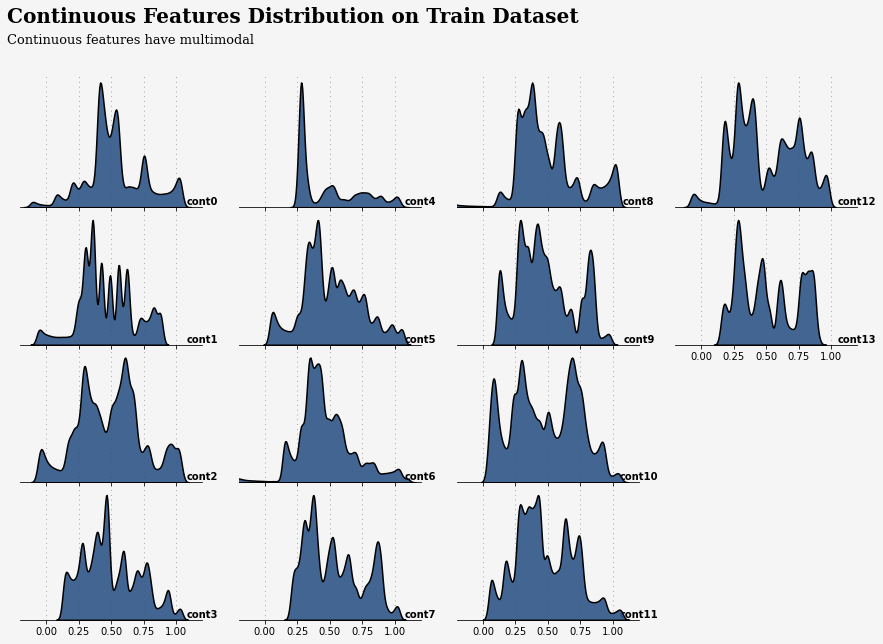

In [8]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 4):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.3, 5.3, 'Continuous Features Distribution on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.3, 4.7, 'Continuous features have multimodal', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(train[col], ax=locals()["ax"+str(run_no)], shade=True, color='#2f5586', edgecolor='black', linewidth=1.5, alpha=0.9, zorder=3)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax14.remove()
ax15.remove()

In [9]:
train[cont_features].describe() # to view some basic statistical details of the continuous features

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992


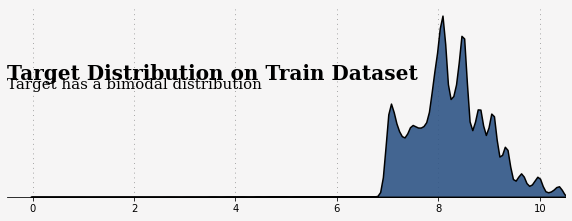

In [10]:
fig = plt.figure(figsize=(10, 3.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

ax0 = fig.add_subplot(gs[0, 0])
ax0.set_facecolor(background_color)
ax0.set_yticklabels([])
ax0.tick_params(axis='y', which=u'both',length=0)
for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

ax0.text(-0.5, 0.5, 'Target Distribution on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.5, 0.46, 'Target has a bimodal distribution', fontsize=15, fontweight='light', fontfamily='serif')        

sns.kdeplot(train['target'], ax=ax0, shade=True, color='#2f5586', edgecolor='black', linewidth=1.5, alpha=0.9, zorder=3)
ax0.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_xlim(-0.5, 10.5)
ax0.set_xlabel('')
ax0.set_ylabel('')

plt.show()

In [11]:
print('Target')
train['target'].describe()

Target


count    300000.000000
mean          8.241979
std           0.746555
min           0.140329
25%           7.742071
50%           8.191373
75%           8.728634
max          10.411992
Name: target, dtype: float64

#### Test dataset

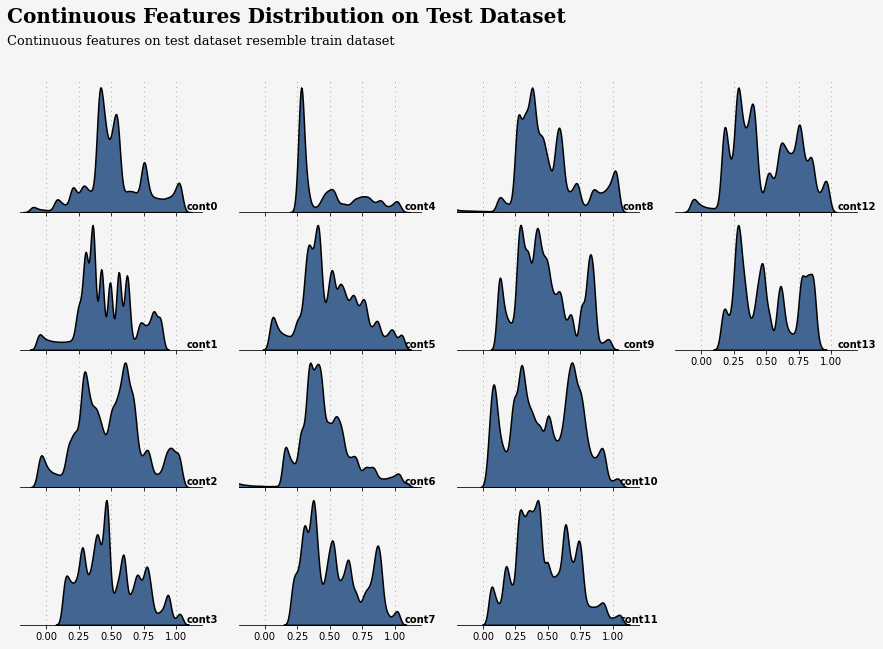

In [12]:
fig = plt.figure(figsize=(15, 10), facecolor='#f6f5f5')
gs = fig.add_gridspec(4, 4)
gs.update(wspace=0.2, hspace=0.05)

background_color = "#f6f5f5"

run_no = 0
for col in range(0, 4):
    for row in range(0, 4):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        locals()["ax"+str(run_no)].set_yticklabels([])
        locals()["ax"+str(run_no)].tick_params(axis='y', which=u'both',length=0)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.3, 5.3, 'Continuous Features Distribution on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.3, 4.7, 'Continuous features on test dataset resemble train dataset', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cont_features:
    sns.kdeplot(test[col], ax=locals()["ax"+str(run_no)], shade=True, color='#2f5586', edgecolor='black', linewidth=1.5, alpha=0.9, zorder=3)
    locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    locals()["ax"+str(run_no)].set_ylabel(col, fontsize=10, fontweight='bold').set_rotation(0)
    locals()["ax"+str(run_no)].yaxis.set_label_coords(1, 0)
    locals()["ax"+str(run_no)].set_xlim(-0.2, 1.2)
    locals()["ax"+str(run_no)].set_xlabel('')
    run_no += 1
    
ax14.remove()
ax15.remove()

In [13]:
test[cont_features].describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.526858,0.460882,0.491686,0.496263,0.492200,0.509944,0.468050,0.537617,0.497587,0.474630,0.473625,0.473589,0.492756,0.508303
std,0.230506,0.213896,0.252852,0.219304,0.240251,0.228100,0.210167,0.218197,0.239337,0.217558,0.255307,0.221844,0.247105,0.222977
min,-0.117993,-0.069316,-0.056095,0.130655,0.255903,0.045921,-0.224613,0.203763,-0.260236,0.117894,0.048734,0.052615,-0.074201,0.151052
25%,0.405787,0.310536,0.302189,0.328865,0.284188,0.353682,0.342813,0.356482,0.332762,0.306940,0.274991,0.308495,0.288094,0.300697
50%,0.496602,0.427656,0.503075,0.464590,0.395080,0.488378,0.429819,0.505216,0.438716,0.434610,0.460042,0.433857,0.422065,0.472446
75%,0.666389,0.615041,0.648234,0.663401,0.697252,0.668586,0.573861,0.703289,0.605368,0.610768,0.690143,0.642201,0.711038,0.758496
max,1.058434,0.887253,1.034687,1.039558,1.055423,1.067641,1.111540,1.032823,1.040208,0.982928,1.055955,1.071445,0.975032,0.906013


### Count of categorical features

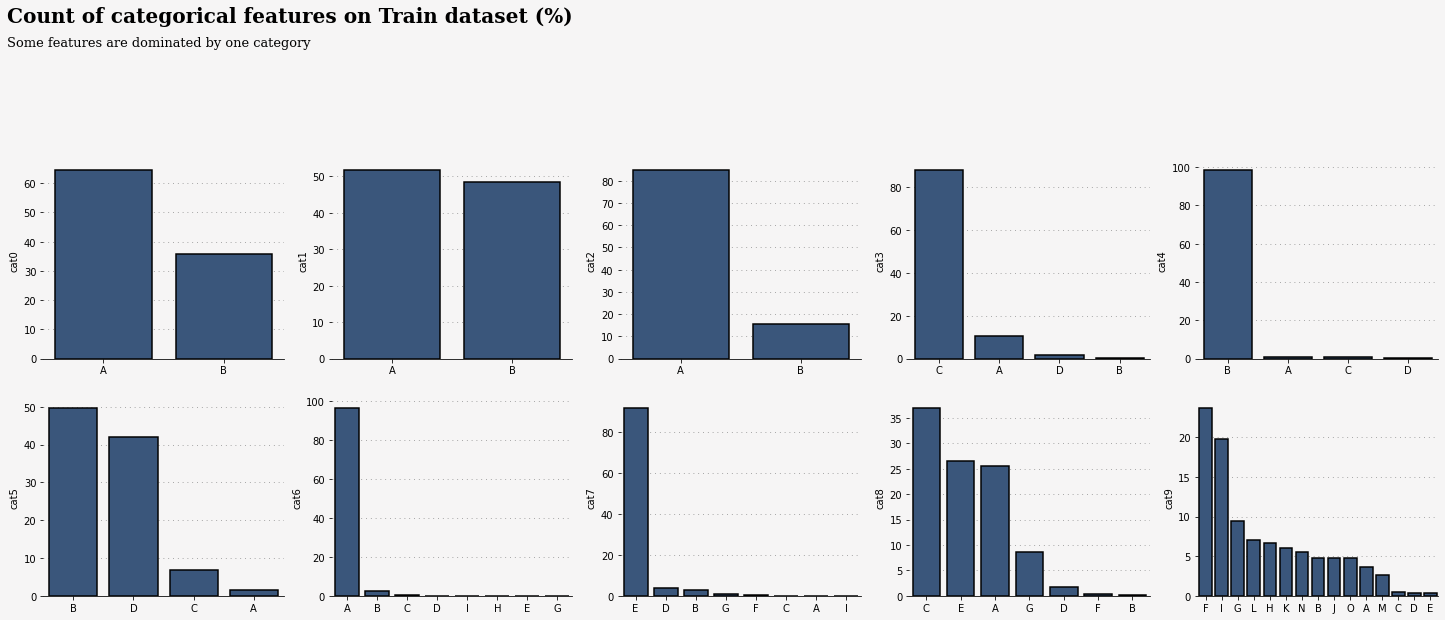

In [14]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(25, 8), facecolor=background_color)
gs = fig.add_gridspec(2, 5)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 2):
    for col in range(0, 5):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 115, 'Count of categorical features on Train dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 107, 'Some features are dominated by one category', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(train[col].value_counts() / len(train) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#2f5586', zorder=3, edgecolor='black', linewidth=1.5)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1

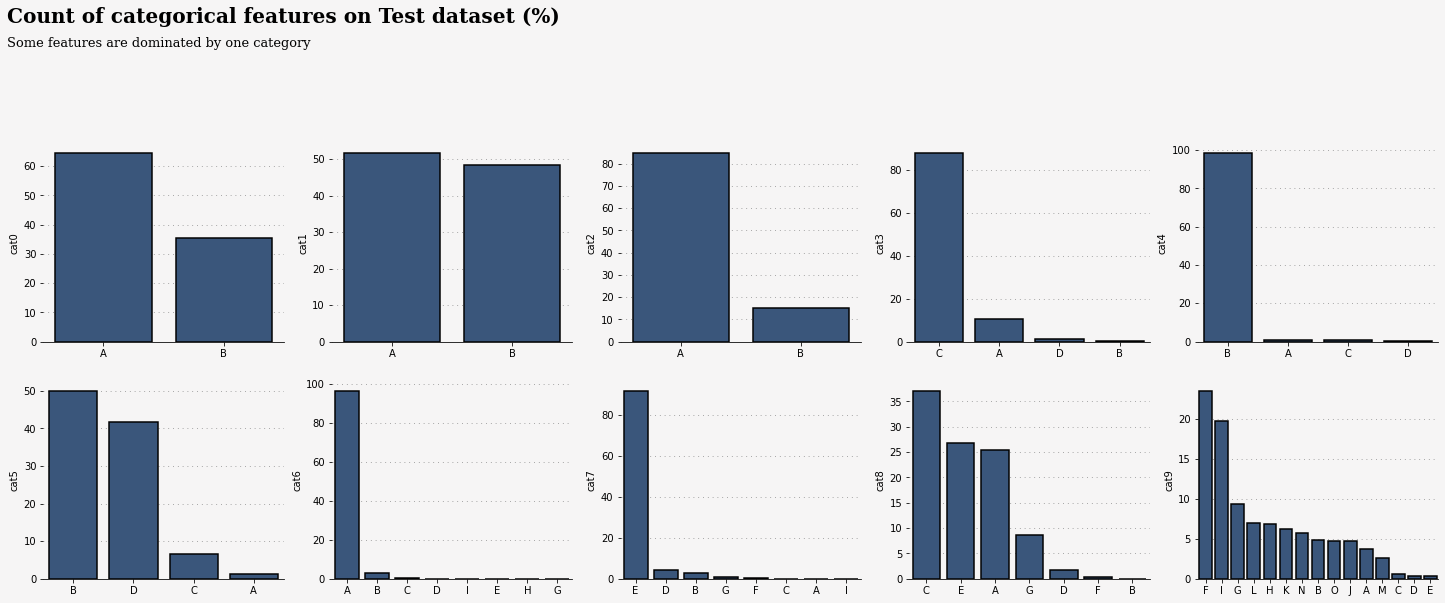

In [15]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(25, 8), facecolor=background_color)
gs = fig.add_gridspec(2, 5)
gs.update(wspace=0.2, hspace=0.2)

run_no = 0
for row in range(0, 2):
    for col in range(0, 5):
        locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(run_no)].set_facecolor(background_color)
        for s in ["top","right", 'left']:
            locals()["ax"+str(run_no)].spines[s].set_visible(False)
        run_no += 1

ax0.text(-0.8, 109, 'Count of categorical features on Test dataset (%)', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(-0.8, 101, 'Some features are dominated by one category', fontsize=13, fontweight='light', fontfamily='serif')        

run_no = 0
for col in cat_features:
    chart_df = pd.DataFrame(test[col].value_counts() / len(test) * 100)
    sns.barplot(x=chart_df.index, y=chart_df[col], ax=locals()["ax"+str(run_no)], color='#2f5586', zorder=3, edgecolor='black', linewidth=1.5)
    locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
    run_no += 1

### Features Correlation

Observations:

- Highest correlation between features is 0.5.
- Correlation between features on train and test dataset are quite similar.

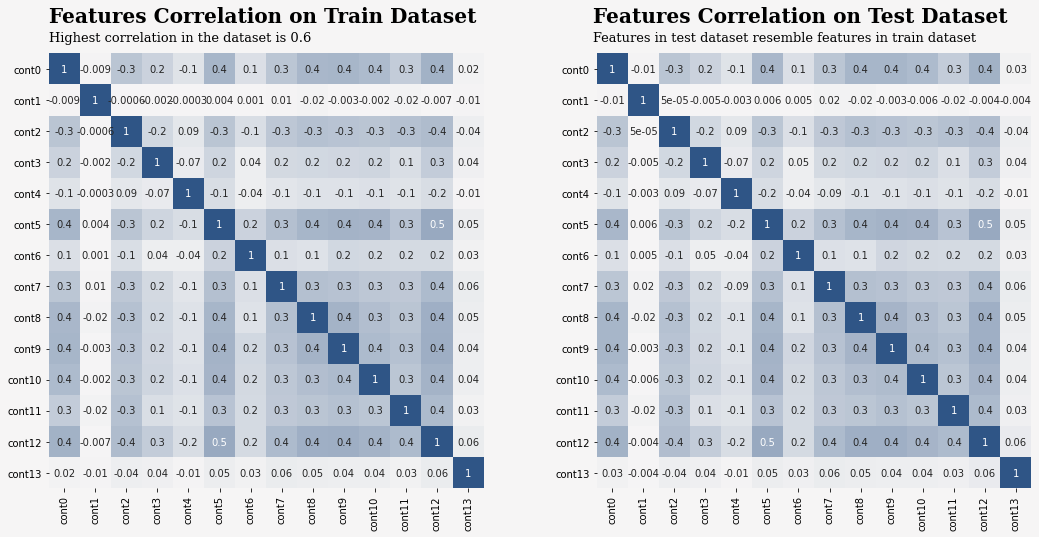

In [16]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#2f5586", "#f6f5f5","#2f5586"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, -1, 'Features Correlation on Train Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax0.text(0, -0.4, 'Highest correlation in the dataset is 0.6', fontsize=13, fontweight='light', fontfamily='serif')

ax1.set_facecolor(background_color)
ax1.text(-0.1, -1, 'Features Correlation on Test Dataset', fontsize=20, fontweight='bold', fontfamily='serif')
ax1.text(-0.1, -0.4, 'Features in test dataset resemble features in train dataset ', 
         fontsize=13, fontweight='light', fontfamily='serif')

sns.heatmap(train[cont_features].corr(), ax=ax0, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

sns.heatmap(test[cont_features].corr(), ax=ax1, vmin=-1, vmax=1, annot=True, square=True, 
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g')

plt.show()

### Feature Engineering

Feature-engineering using histograms of the cont features show multiple components. For instance, the `cont1` has 7 discrete peaks as shown below. 

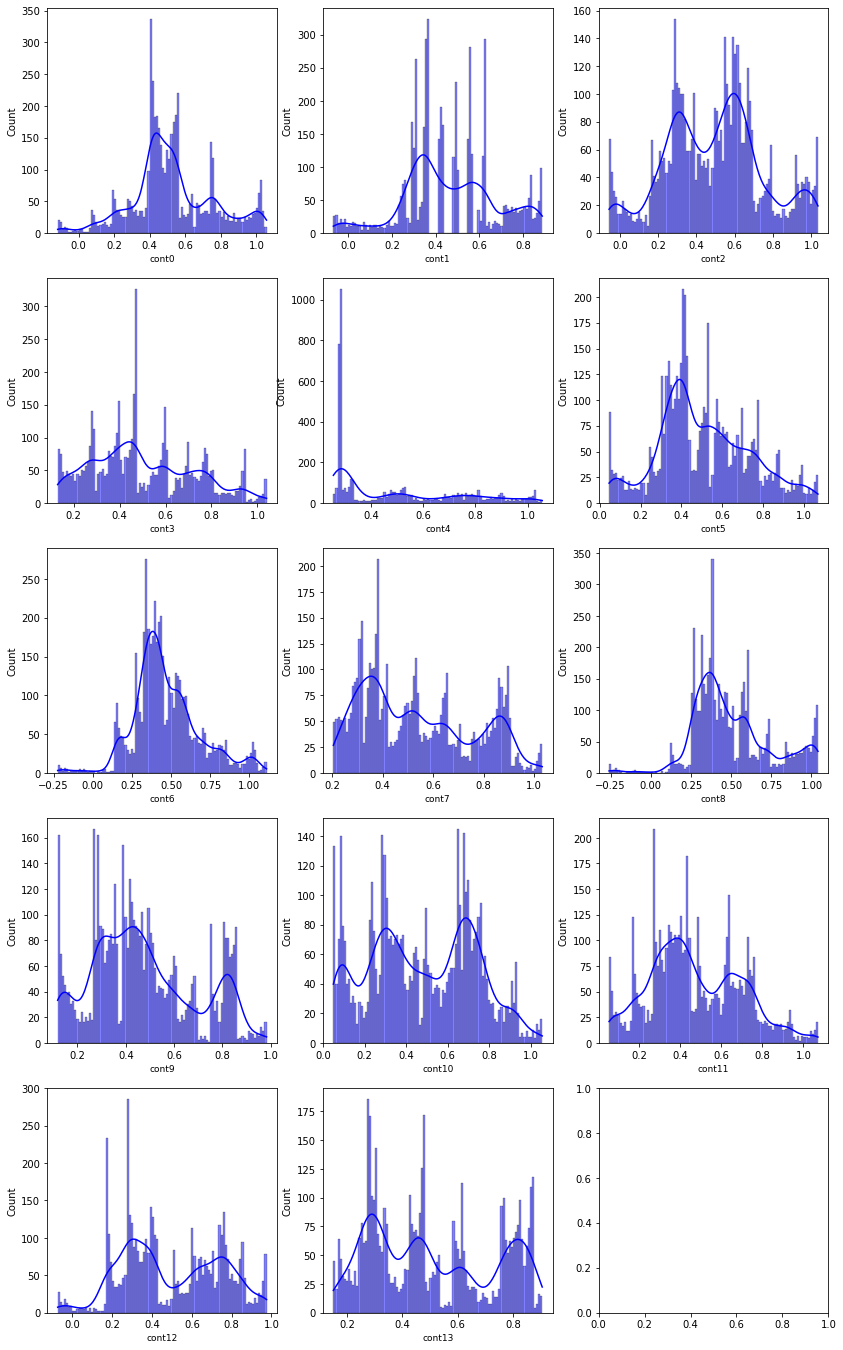

In [17]:
all_data = pd.concat([train, test])

fig, ax = plt.subplots(5, 3, figsize=(14, 24))
for i, feature in enumerate(cont_features):
    plt.subplot(5, 3, i+1)
    sns.histplot(all_data[feature][::100], 
                 color="blue", 
                 kde=True, 
                 bins=100)
    plt.xlabel(feature, fontsize=9)
plt.show()

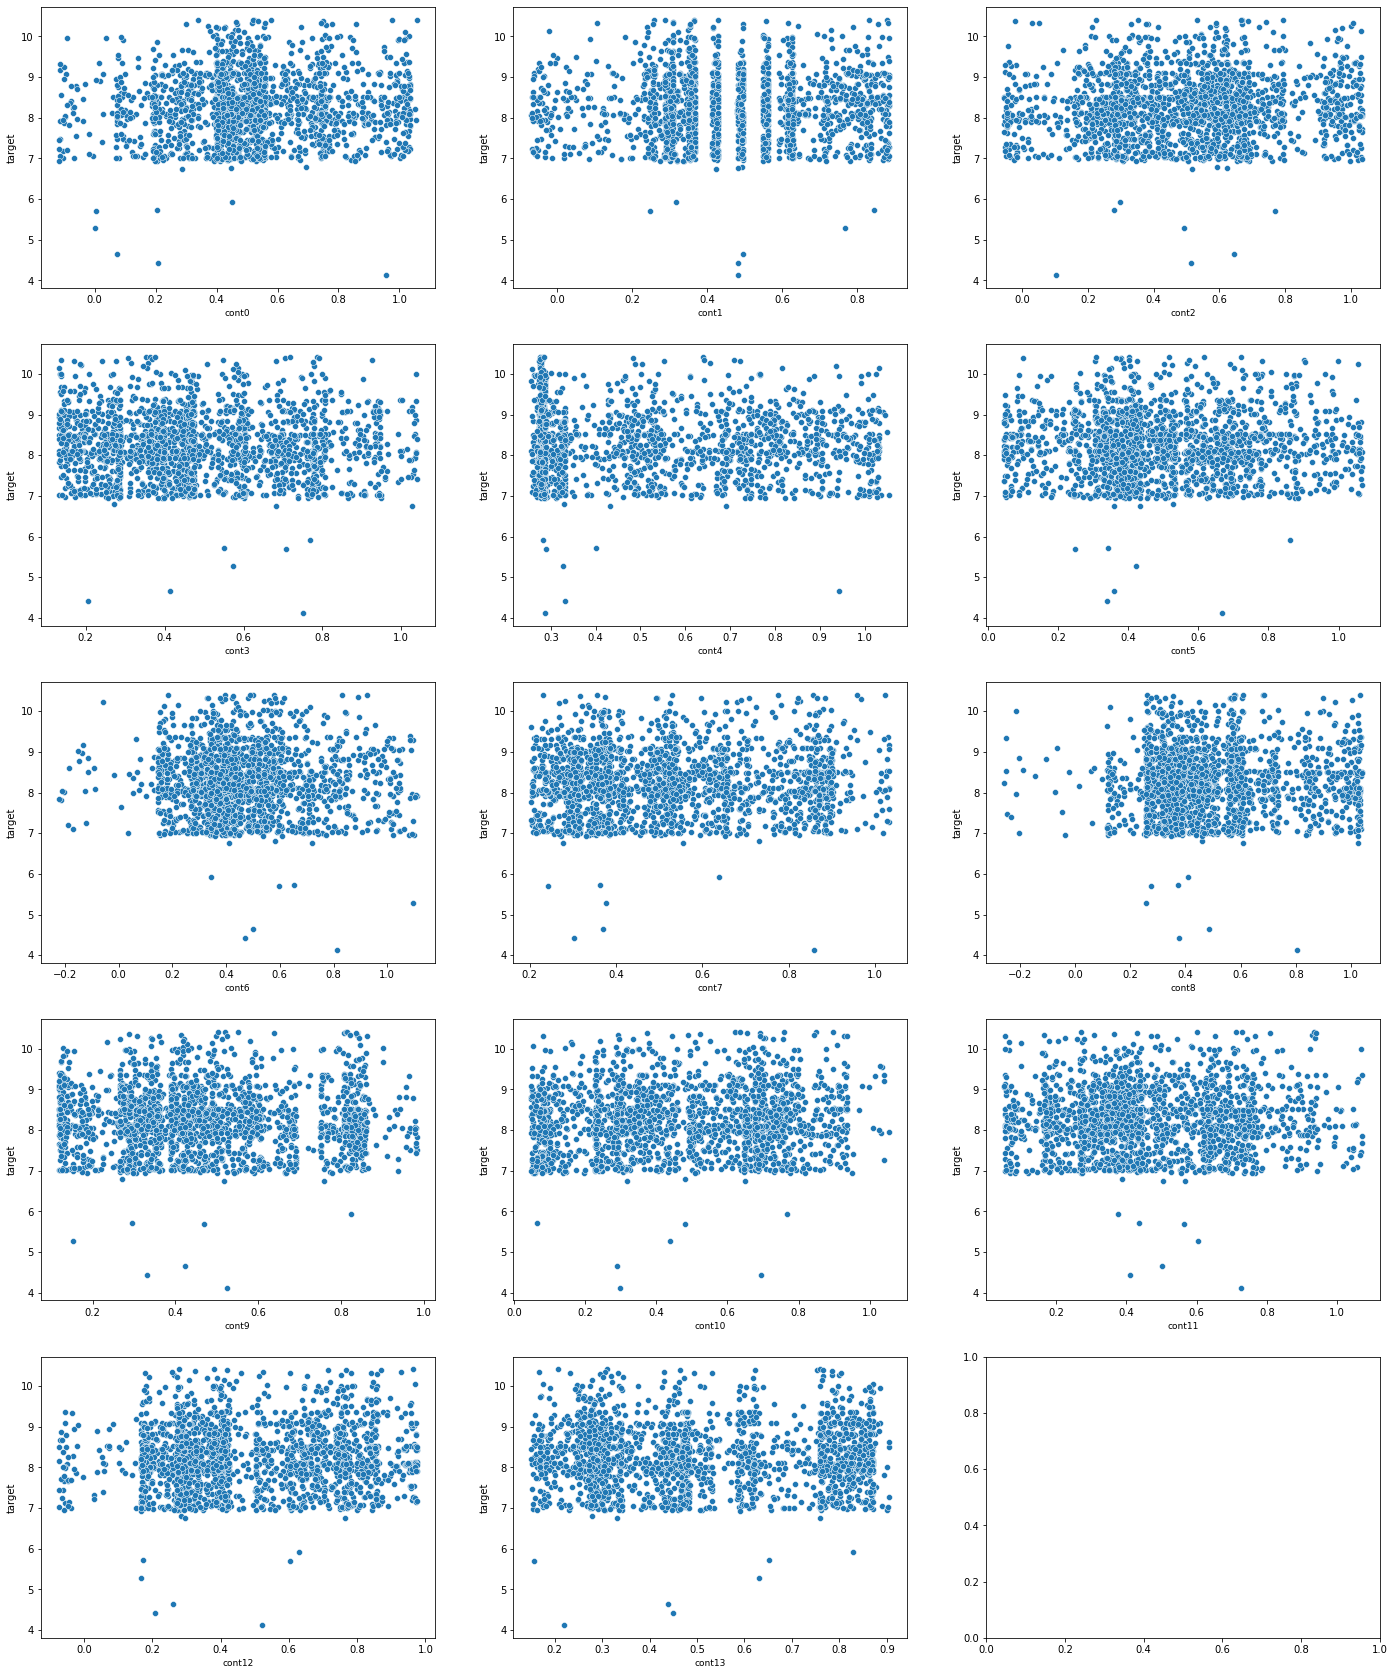

In [18]:
fig, ax = plt.subplots(5, 3, figsize=(24, 30))
for i, feature in enumerate(cont_features):
    plt.subplot(5, 3, i+1)
    sns.scatterplot(x=feature, 
                    y="target", 
                    data=train[::150], 
                    palette='muted')
    plt.xlabel(feature, fontsize=9)
plt.show()

# Step 4: Prepare the data

The next code cell separates the target (which we assign to `y`) from the training features (which we assign to `features`).

In [19]:
# Separate target from features
y = train['target']
features = train.drop(['target'], axis=1)

# List of features for later use
feature_list = list(features.columns)

# Preview features
features.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,B,B,A,A,B,D,A,F,A,O,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,A,A,A,C,B,D,A,D,A,F,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,B,B,A,C,B,D,A,E,C,K,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,A,A,A,C,B,D,A,E,A,N,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


Now, we'll need to handle the categorical columns (`cat0`, `cat1`, ... `cat9`).  

From the lesson **[Categorical Variables lesson](https://www.kaggle.com/alexisbcook/categorical-variables)**, we'll use ordinal encoding and save our encoded features as new variables `X` and `X_test`.

#### What is Ordinal Encoder and why we choose it?
In ordinal encoding, each unique category value is assigned an integer value. The encoding involves mapping each unique label to an integer value.
For example, `red` is 1, `green` is 2, and `blue` is 3.

This is called an ordinal encoding or an integer encoding and is easily reversible. Often, integer values starting at zero are used. The integer values have a natural ordered relationship between each other and machine learning algorithms may be able to understand and harness this relationship.

In [20]:
# List of categorical columns
object_cols = [col for col in features.columns if 'cat' in col]

# ordinal-encode categorical columns
X = features.copy()
X_test = test.copy()

# ordinal encode input variables
ordinal_encoder = OrdinalEncoder()
X[object_cols] = ordinal_encoder.fit_transform(features[object_cols])
X_test[object_cols] = ordinal_encoder.transform(test[object_cols])

# Preview the ordinal-encoded features
X.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,2.0,1.0,1.0,0.0,4.0,2.0,13.0,...,0.610706,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850
2,1.0,1.0,0.0,0.0,1.0,3.0,0.0,5.0,0.0,14.0,...,0.276853,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083
3,0.0,0.0,0.0,2.0,1.0,3.0,0.0,3.0,0.0,5.0,...,0.285074,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846
4,1.0,1.0,0.0,2.0,1.0,3.0,0.0,4.0,2.0,10.0,...,0.284667,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682
6,0.0,0.0,0.0,2.0,1.0,3.0,0.0,4.0,0.0,13.0,...,0.287595,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823


We can also prepare the target in the same manner. Ordinal encoding of target variable uses LabelEncoder(). But we do not use it here since it is used to normalize labels, and to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels. Since our target is already numeric, we do not need it here.

Next, we break off a validation set from the training data.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.2)

# Step 5: Train a model

Now that the data is prepared, the next step is to train a model.  

## 5.1: Random Forest

From the lesson **[Random Forests](https://www.kaggle.com/dansbecker/random-forests)**, we learnt how to fit a random forest model to the data.

#### What is Random Forest, and why are we using it here?

Random forest is a type of supervised learning algorithm that uses ensemble methods (bagging) to solve both regression and classification problems. The algorithm operates by constructing a multitude of decision trees at training time and outputting the mean/mode of prediction of the individual trees.

- Each tree is created from a different sample of rows and at each node, a different sample of features is selected for splitting. 
- Each of the trees makes its own individual prediction. 
- These predictions are then averaged to produce a single result. 

![Random Forest](https://upload.wikimedia.org/wikipedia/commons/7/76/Random_forest_diagram_complete.png)

The averaging makes a Random Forest better than a single Decision Tree hence improves its accuracy and reduces overfitting. 

A prediction from the Random Forest Regressor is an average of the predictions produced by the trees in the forest. 

In [22]:
# Define the model 
model_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
# Train the model
model_rf.fit(X_train, y_train)
preds_valid = model_rf.predict(X_valid)
print(mean_squared_error(y_valid, preds_valid, squared=False))

0.731691754784104


In the code cell above, we set `squared=False` to get the root mean squared error (RMSE) on the validation data.

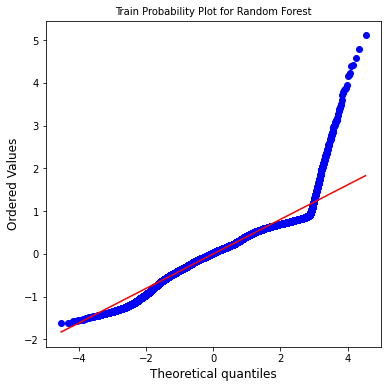

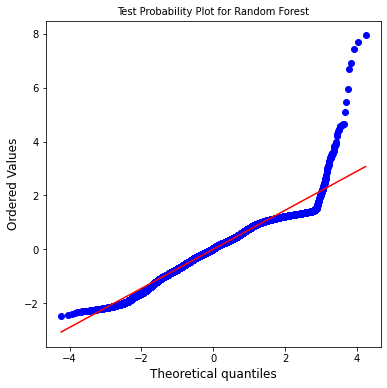

In [23]:
plt.rcParams["axes.labelsize"] = 12
rf_prob_train = model_rf.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(rf_prob_train, plot=plt, fit=True)
plt.title('Train Probability Plot for Random Forest', fontsize=10)
plt.show()

rf_prob_test = model_rf.predict(X_valid) - y_valid
plt.figure(figsize=(6,6))
sp.stats.probplot(rf_prob_test, plot=plt, fit=True)
plt.title('Test Probability Plot for Random Forest', fontsize=10)
plt.show()

But when the Random Forest Regressor is tasked with the problem of predicting for values not previously seen, it will always predict an average of the values seen previously. Meaning, that the Random Forest Regressor is unable to discover trends that would enable it in extrapolating values that fall outside the training set. 

The random forest performs implicit feature selection because it splits nodes on the most important variables, but other machine learning models do not. One approach to improve the models is therefore to use the random forest feature importances to reduce the number of variables in the problem. In our case, we will use the feature importances to decrease the number of features for our random forest model, because, in addition to potentially increasing performance, reducing the number of features will shorten the run time of the model. Let's see if it improves the accuracy of our model.

In [24]:
# Get numerical feature importances
importances = list(model_rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: cont2                Importance: 0.07
Variable: cont9                Importance: 0.07
Variable: cont10               Importance: 0.07
Variable: cont12               Importance: 0.07
Variable: cont0                Importance: 0.06
Variable: cont1                Importance: 0.06
Variable: cont3                Importance: 0.06
Variable: cont4                Importance: 0.06
Variable: cont5                Importance: 0.06
Variable: cont6                Importance: 0.06
Variable: cont7                Importance: 0.06
Variable: cont8                Importance: 0.06
Variable: cont11               Importance: 0.06
Variable: cont13               Importance: 0.06
Variable: cat9                 Importance: 0.03
Variable: cat8                 Importance: 0.02
Variable: cat0                 Importance: 0.01
Variable: cat1                 Importance: 0.01
Variable: cat2                 Importance: 0.01
Variable: cat3                 Importance: 0.01
Variable: cat5                 Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

These stats definitely prove that some variables are much more important to our problem than others! Given that there are so many variables with zero importance (or near-zero due to rounding). But it seems like we should be able to get rid of some of them without impacting performance.

The following graph represents the relative differences in feature importances.

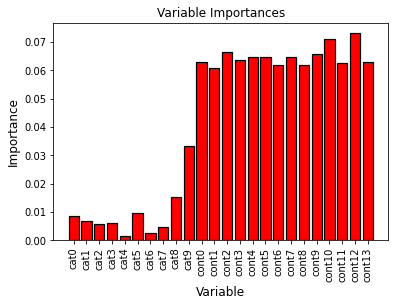

In [25]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Consequently, we can also make a cumulative importance graph that shows the contribution to the overall importance of each additional variable. The dashed line is drawn at 95% of total importance accounted for.

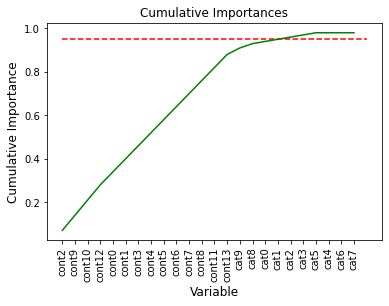

In [26]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

We can now use this to remove unimportant features. 95% is an arbitrary threshold, but if it leads to noticeably poor performance we can adjust the value. First, we need to find the exact number of features to exceed 95% importance:

In [27]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 18


We see that almost all of our features are important. But we can check that further by creating a new training and testing set retaining only the 18 most important features, and using the model on it.

In [28]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:17]]
# Create training and testing sets with only the important features
important_train_features = X_train[important_feature_names]
important_test_features = X_valid[important_feature_names]
# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (240000, 17)
Important test features shape: (60000, 17)


We first test the accuracy with the selected features.

In [29]:
# Train the expanded model on only the important features
model_rf.fit(important_train_features, y_train);
# Make predictions on test data
new_predictions = model_rf.predict(important_test_features)
# Performance metrics
errors = mean_squared_error(y_valid, new_predictions, squared=False)
print('RMSE:', errors)
# Calculate rmse
rmse = np.mean(100 * (errors / y_valid))
# Calculate and display accuracy
accuracy = 100 - rmse
print('Accuracy:', round(accuracy, 2), '%.')

RMSE: 0.7323232877219819
Accuracy: 91.03 %.


Now with the original features. _(We are re-training it back to fit the original features)_

In [30]:
# Train the model first on the original features
model_rf.fit(X_train, y_train);
# Make predictions on test data
predictions = model_rf.predict(X_valid)
# Performance metrics
errors = mean_squared_error(y_valid, predictions, squared=False)
print('Metrics for Random Forest Trained on original Data')
print('RMSE:', errors)
# Calculate rmse
rmse_new = np.mean(100 * (errors / y_valid))
# Calculate and display accuracy
accuracy = 100 - rmse_new
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on original Data
RMSE: 0.7314843327965497
Accuracy: 91.04 %.


This is just an instance of feature selection with one of our models. But since we do not see any improvement, we move forward without the selected features for our dataset.

Let's check the feature importances for the model. 

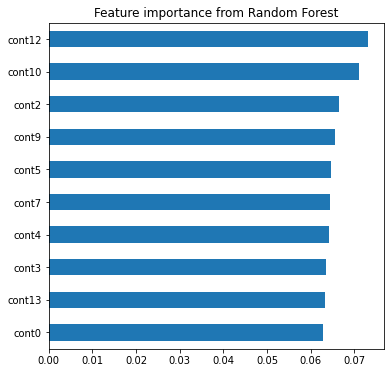

In [31]:
pd.Series(model_rf.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh',
                                                                               figsize = (6, 6),
                                                                              title = 'Feature importance from Random Forest').invert_yaxis();

Following the same pattern, we try it with on other models.

## 5.2: XGBoost

From the lesson **[XGBoost](https://www.kaggle.com/alexisbcook/xgboost)**, we learnt how to fit a XGBoost model to the data.

#### What is XGBoost?
XGBoost is termed as Extreme Gradient Boosting Algorithm which is again an ensemble method that works by boosting trees. XGboost makes use of a gradient descent algorithm which is the reason that it is called Gradient Boosting. The whole idea is to correct the previous mistake done by the model, learn from it and its next step improves the performance. The previous results are rectified and performance is enhanced.

![XGBoost Regressor](https://miro.medium.com/max/1400/1*FLshv-wVDfu-i54OqvZdHg.png)

#### Why is it preferred?
- Speed and perfoermance: Comparatively faster than other ensemble classifiers
- Core algorithm is parallelizable: Because the core XGBoost algorithm is parallelizable it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.
- Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.
- Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc.



In [32]:
xgb_params = {'objective': 'reg:squarederror',
              'n_estimators': 10000,
              'learning_rate': 0.25,
              'subsample': 0.926,
              'colsample_bytree': 0.84,
              'grow_policy':'lossguide',
              'max_depth': 2,
              'booster': 'gbtree', 
              'reg_lambda': 45.1,
              'reg_alpha': 34.9,
              'random_state': 42,
              'n_jobs': 4}

model_XGB = XGBRegressor(**xgb_params)
model_XGB.fit(X_train, y_train) 
predictions_XGB = model_XGB.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB, squared=False))

0.7185401438388371


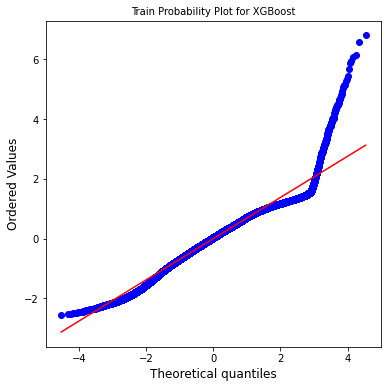

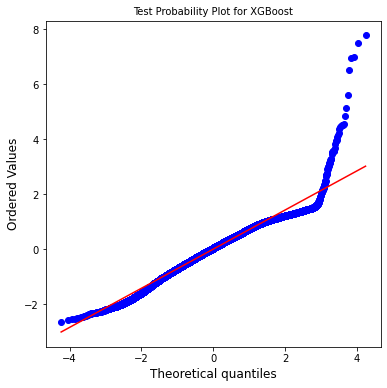

In [33]:
plt.rcParams["axes.labelsize"] = 12
xgb_prob_train = model_XGB.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(xgb_prob_train, plot=plt, fit=True)
plt.title('Train Probability Plot for XGBoost', fontsize=10)
plt.show()

xgb_prob_test = model_XGB.predict(X_valid) - y_valid
plt.figure(figsize=(6,6))
sp.stats.probplot(xgb_prob_test, plot=plt, fit=True)
plt.title('Test Probability Plot for XGBoost', fontsize=10)
plt.show()

Comparing the feature importances as before, we see for XGBoost, the outcome is slightly different than Random Forest.

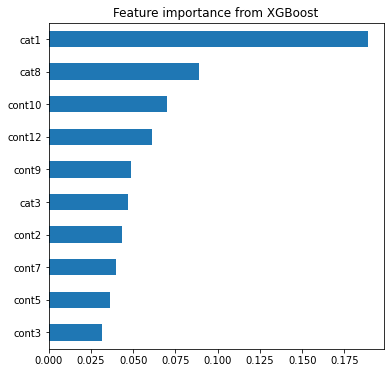

In [34]:
pd.Series(model_XGB.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh',
                                                                               figsize = (6, 6),
                                                                              title = 'Feature importance from XGBoost').invert_yaxis();


Now, let's train our dataset in XFBoost with other different parameters.

In [35]:
xgb_1_params = {
    'n_estimators': 5000,
    'learning_rate': 0.12,
    'subsample': 0.96,
    'colsample_bytree': 0.12,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 65.1,
    'reg_alpha': 15.9,
    'random_state':40
    }

model_XGB_1 = XGBRegressor(**xgb_1_params)
model_XGB_1.fit(X_train, y_train) 
predictions_XGB_1 = model_XGB_1.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_1, squared=False))

0.7161073563345782


In [36]:
xgb_2_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 5000,
    'learning_rate': 0.12,
    'subsample': 0.96,
    'colsample_bytree': 0.12,
    'max_depth': 2,
    'booster': 'gbtree', 
    'reg_lambda': 65.1,
    'reg_alpha': 15.9,
    'random_state':40
}

model_XGB_2 = XGBRegressor(**xgb_2_params)
model_XGB_2.fit(X_train, y_train) 
predictions_XGB_2 = model_XGB_2.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_2, squared=False))

0.7161073563345782


In [37]:
xgb_3_params = {
    'objective': 'reg:squarederror',
    "learning_rate" : 0.05,
    'n_estimators': 5000,
    "max_depth":12,
    "min_child_weight" :110,
    "gamma" :0.01,
    'booster': 'gbtree', 
    "subsample" : 0.7,
    "colsample_bytree" : 0.1,
    "reg_lambda" :65,
    "reg_alpha":71,
    "max_delta_step":10}

model_XGB_3 = XGBRegressor(**xgb_3_params)
model_XGB_3.fit(X_train, y_train) 
predictions_XGB_3 = model_XGB_3.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_3, squared=False))

0.7166334438641611


In [38]:
xgb_4_params = {
    'random_state': 1, 
    'n_jobs': 4,
    'booster': 'gbtree',
    'n_estimators': 10000,
    'learning_rate': 0.03628302216953097,
    'reg_lambda': 0.0008746338866473539,
    'reg_alpha': 23.13181079976304,
    'subsample': 0.7875490025178415,
    'colsample_bytree': 0.11807135201147481,
    'max_depth': 3}

model_XGB_4 = XGBRegressor(**xgb_4_params)
model_XGB_4.fit(X_train, y_train) 
predictions_XGB_4 = model_XGB_4.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_4, squared=False))

0.7156774204328461


In [39]:
xgb_5_params = {'learning_rate': 0.07853392035787837, 
          'reg_lambda': 1.7549293092194938e-05, 
          'reg_alpha': 14.68267919457715, 
          'subsample': 0.8031450486786944, 
          'colsample_bytree': 0.170759104940733, 
          'max_depth': 3,
          'n_estimators': 5000
         }
model_XGB_5 = XGBRegressor(**xgb_5_params)
model_XGB_5.fit(X_train, y_train) 
predictions_XGB_5 = model_XGB_5.predict(X_valid)
print(mean_squared_error(y_valid, predictions_XGB_5, squared=False))

0.7163914915627733


## 5.3: LightGBM

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, used for ranking, classification and many other machine learning tasks. Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

![LightGBM](https://miro.medium.com/max/1400/1*mKkwlQF25Rq1ilne5UiEXA.png)

#### Advantages of Light GBM
- Faster training speed and higher efficiency: Light GBM use histogram based algorithm i.e it buckets continuous feature values into discrete bins which fasten the training procedure.
- Lower memory usage: Replaces continuous values to discrete bins which result in lower memory usage.
- Better accuracy than any other boosting algorithm: It produces much more complex trees by following leaf wise split approach rather than a level-wise approach which is the main factor in achieving higher accuracy. However, it can sometimes lead to overfitting which can be avoided by setting the max_depth parameter.
- Compatibility with Large Datasets: It is capable of performing equally good with large datasets with a significant reduction in training time as compared to XGBOOST.
- Parallel learning supported.

In [40]:
lgbm_parameters = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'lambda_l1': 0.45,
    'lambda_l2': 4.8,
    'learning_rate': 0.005,
    'num_trees': 80000,
    'num_leaves': 10, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 1.0, 
    'bagging_freq': 0, 
    'min_child_samples': 100,
    'num_threads': 4
}

lgbm_model = LGBMRegressor(**lgbm_parameters)
lgbm_model.fit(X_train, y_train, eval_set = ((X_valid,y_valid)),verbose = -1, early_stopping_rounds = 1000,categorical_feature=object_cols) 
predictions_LGBM = lgbm_model.predict(X_valid)
print(mean_squared_error(y_valid, predictions_LGBM, squared=False))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=0.45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.45
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.8, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] num_iterations is set=80000, num_trees=80000 will be ignored. Current value: num_iterations=80000


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[34543]	valid_0's rmse: 0.718327
0.7183268257820973


As we can see, it gives a better result than XGBoost. LightGBM, apart from being more accurate and time-saving than XGBOOST has been limited in usage due to less documentation available. However, this algorithm has shown far better results and has outperformed existing boosting algorithms.

![Comparison](https://image.slidesharecdn.com/xgboostandlightgbm-180201121028/95/xgboost-lightgbm-21-638.jpg?cb=1517487076)

Following are the probability plot of LGBM and the feature importance for the model.

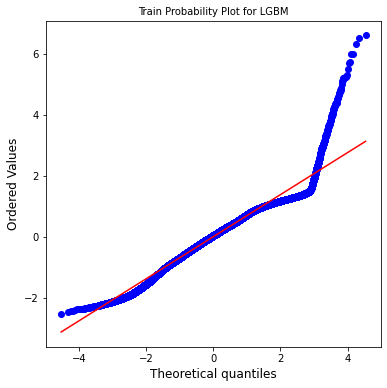

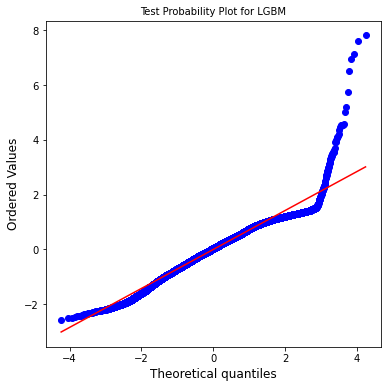

In [41]:
plt.rcParams["axes.labelsize"] = 12
lgbm_prob_train = lgbm_model.predict(X_train) - y_train
plt.figure(figsize=(6,6))
sp.stats.probplot(lgbm_prob_train, plot=plt, fit=True)
plt.title('Train Probability Plot for LGBM', fontsize=10)
plt.show()

lgbm_prob_test = lgbm_model.predict(X_valid) - y_valid
plt.figure(figsize=(6,6))
sp.stats.probplot(lgbm_prob_test, plot=plt, fit=True)
plt.title('Test Probability Plot for LGBM', fontsize=10)
plt.show()

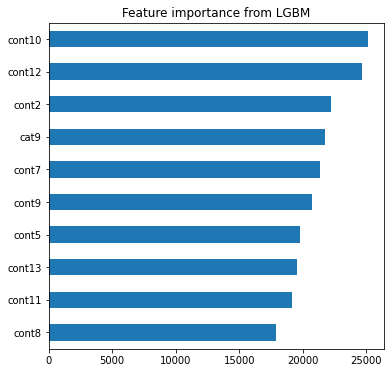

In [42]:
pd.Series(lgbm_model.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh',
                                                                               figsize = (6, 6),
                                                                              title = 'Feature importance from LGBM').invert_yaxis();


Training with varied parameters of LGBM model.

In [43]:
lgbm_parameters_1 = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'reg_alpha': 0.4972562469417825, 
    'reg_lambda': 0.3273637203281044, 
    'num_leaves': 50, 
    'learning_rate': 0.032108486615557354,                      
    'max_depth': 40,                     
    'n_estimators': 4060, 
    'min_child_weight': 0.0173353329222102,
    'subsample': 0.9493343850444064, 
    'colsample_bytree': 0.5328221263825876, 
    'min_child_samples': 80
}

lgbm_model_1 = LGBMRegressor(**lgbm_parameters_1)
lgbm_model_1.fit(X_train, y_train, eval_set = ((X_valid,y_valid)),verbose = -1, early_stopping_rounds = 1000,categorical_feature=object_cols) 
predictions_LGBM_1 = lgbm_model_1.predict(X_valid)
print(mean_squared_error(y_valid, predictions_LGBM_1, squared=False))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 1000 rounds
Early stopping, best iteration is:
[1481]	valid_0's rmse: 0.719918
0.7199178355503685


In [44]:
lgbm_parameters_2 = {
    'metric': 'RMSE',
    'feature_pre_filter': False,
    'reg_alpha': 0.4994758073847213, 
    'reg_lambda': 0.32496035638807086, 
    'num_leaves': 55, 
    'learning_rate': 0.03292764050310852, 
    'max_depth': 32, 
    'n_estimators': 6059, 
    'min_child_weight': 0.018085927063358823, 
    'subsample': 0.9553223859131216, 
    'colsample_bytree': 0.5253243484788512, 
    'min_child_samples': 77
}

lgbm_model_2 = LGBMRegressor(**lgbm_parameters_2)
lgbm_model_2.fit(X_train, y_train, eval_set = ((X_valid,y_valid)),verbose = -1, early_stopping_rounds = 2000,categorical_feature=object_cols) 
predictions_LGBM_2 = lgbm_model_2.predict(X_valid)
print(mean_squared_error(y_valid, predictions_LGBM_2, squared=False))

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1706: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 2000 rounds
Early stopping, best iteration is:
[1208]	valid_0's rmse: 0.719881
0.7198805848572547


## 5.4: CatBoost
CatBoost is an algorithm for gradient boosting on decision trees. And it is the only boosting algorithm with very less prediction time. Because of its symmetric tree structure. It is comparatively 8x faster than XGBoost while predicting. One main difference between CatBoost and other boosting algorithms is that the CatBoost implements symmetric trees. Though when datasets have many numerical features (like this one), CatBoost takes so much time to train than Light GBM.

But CatBoost also offers an idiosyncratic way of handling categorical data, requiring a minimum of categorical feature transformation, opposed to the majority of other machine learning algorithms, that cannot handle non-numeric values. From a feature engineering perspective, the transformation from a non-numeric state to numeric values can be a very non-trivial and tedious task, and CatBoost makes this step obsolete. (Though here, we had used feature engineering for conducting training in all the models)

![CatBoost](https://www.kdnuggets.com/wp-content/uploads/mwiti-catboost-0.png)

In [45]:
cat_parameters_1 = {    
    'iterations':1600,
    'learning_rate':0.024,
    'l2_leaf_reg':20,
    'random_strength':1.5,
    'grow_policy':'Depthwise',
    'leaf_estimation_method':'Newton', 
    'bootstrap_type':'Bernoulli',
    'thread_count':4,
    'verbose':False,
    'loss_function':'RMSE',
    'eval_metric':'RMSE',
    'od_type':'Iter'
}

cat_model_1 = CatBoostRegressor(**cat_parameters_1)
cat_model_1.fit(X_train, y_train, verbose =200) 
predictions_cat_1 = cat_model_1.predict(X_valid)
print(mean_squared_error(y_valid, predictions_cat_1, squared=False))

0:	learn: 0.7464904	total: 151ms	remaining: 4m
200:	learn: 0.7308795	total: 12.7s	remaining: 1m 28s
400:	learn: 0.7261869	total: 24.9s	remaining: 1m 14s
600:	learn: 0.7214357	total: 35.8s	remaining: 59.6s
800:	learn: 0.7156556	total: 46.5s	remaining: 46.4s
1000:	learn: 0.7108888	total: 57.4s	remaining: 34.4s
1200:	learn: 0.7069343	total: 1m 8s	remaining: 22.6s
1400:	learn: 0.7032917	total: 1m 18s	remaining: 11.2s
1599:	learn: 0.6999247	total: 1m 29s	remaining: 0us
0.7198383870414209


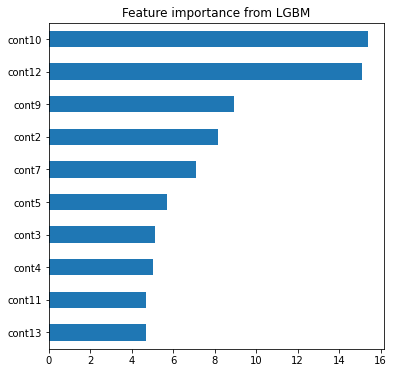

In [46]:
pd.Series(cat_model_1.feature_importances_, index = X_train.columns).nlargest(10).plot(kind = 'barh',
                                                                               figsize = (6, 6),
                                                                              title = 'Feature importance from LGBM').invert_yaxis();


# Step 6: Feature importances
Now, let's compare all of the models together along with their feature importances in the following graph.

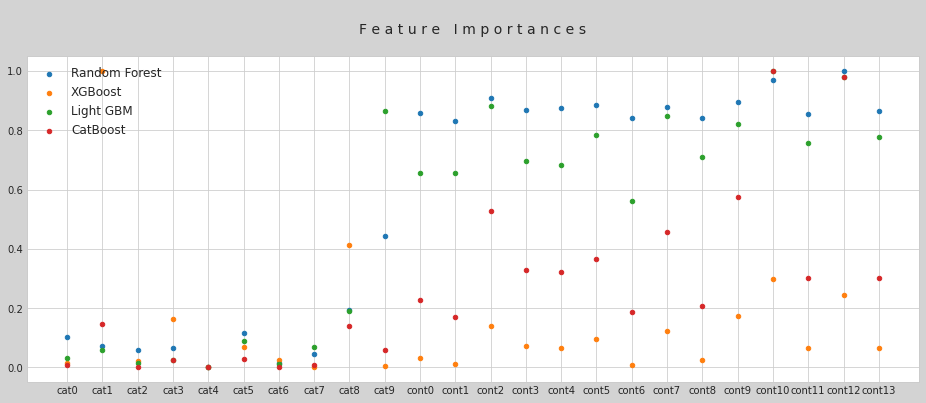

In [47]:
a1 = model_rf.feature_importances_
a2 = model_XGB.feature_importances_
a3 = lgbm_model.feature_importances_
a4 = cat_model_1.feature_importances_

axis_x  = X.columns.values
axis_y1 = minmax_scaling(a1, columns=[0])
axis_y2 = minmax_scaling(a2, columns=[0])
axis_y3 = minmax_scaling(a3, columns=[0])
axis_y4 = minmax_scaling(a4, columns=[0])

plt.style.use('seaborn-whitegrid') 
plt.figure(figsize=(16, 6), facecolor='lightgray')
plt.title(f'\nF e a t u r e   I m p o r t a n c e s\n', fontsize=14)  

plt.scatter(axis_x, axis_y1, s=20, label='Random Forest') 
plt.scatter(axis_x, axis_y2, s=20, label='XGBoost')
plt.scatter(axis_x, axis_y3, s=20, label='Light GBM') 
plt.scatter(axis_x, axis_y4, s=20, label='CatBoost')

plt.legend(fontsize=12, loc=2)
plt.show()

#### Why are we using only one of the models of each regressor to check the most important features for those models?
That's because the feature importances depend on the models, not on the parameters. We can check with any variations of the parameters for each of the regressors.

# Step 7: Submit to the competition

We'll begin by using the trained model to generate predictions, which we'll save to a CSV file.

### But which model to use for prediction?

Maybe we should try to use all of the models we trained! Here is a fun way to put weightage to the predictions of all the models to get the final outcome. 

*NOTE:* Remember to put more weightage on the models with lesser RMSE value to get the best result. 

### Ensemble
Try ensembling. Using model blending weights optimisation technique similar to the one used in [this](https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0) notebook, we have tried it on our models. Ensembling different models can be necessary to improve scores.

In [48]:
# Use the models to generate predictions
pred_1 = model_rf.predict(X_test)
pred_2 = model_XGB.predict(X_test)
pred_3 = model_XGB_1.predict(X_test)
pred_4 = model_XGB_2.predict(X_test)
pred_5 = model_XGB_3.predict(X_test)
pred_6 = model_XGB_4.predict(X_test)
pred_7 = model_XGB_5.predict(X_test)
pred_8 = lgbm_model.predict(X_test)
pred_9 = lgbm_model_1.predict(X_test)
pred_10= lgbm_model_2.predict(X_test)
pred_11 = cat_model_1.predict(X_test)

# Make sure to check that the weights sum up to ~1 by averaging the weights later 
preds = [pred_1, pred_2, pred_3, pred_4, pred_5, pred_6, pred_7, pred_8, pred_9, pred_10, pred_11]
weights = [0., 1., 5000., 1000., 900., 1000., 100., 90., 5., 1., 1.] 

sample_submission = pd.read_csv("../input/30-days-of-ml/sample_submission.csv")
sample_submission.target = 0.0

for pred, weight in zip(preds, weights):
    sample_submission.target += weight * pred / sum(weights)

sample_submission.to_csv('submission.csv', index=False)

In [49]:
sample_submission.head()

,id,target
0,0,8.105170
1,5,8.406533
2,15,8.438270
3,16,8.456850
4,17,8.133658
